Starting sales forecasting pipeline at 2025-04-28 16:06:53.451376
Loading and exploring data...
Dataset shape: (500, 9)

First 5 rows:
     customer name                                    customer e-mail  \
0    Martina Avila  cubilia.Curae.Phasellus@quisaccumsanconvallis.edu   
1    Harlan Barnes                                eu.dolor@diam.co.uk   
2  Naomi Rodriquez  vulputate.mauris.sagittis@ametconsectetueradip...   
3  Jade Cunningham                            malesuada@dignissim.com   
4     Cedric Leach     felis.ullamcorper.viverra@egetmollislectus.net   

        country  gender        age  annual Salary  credit card debt  \
0      Bulgaria       0  41.851720    62812.09301      11609.380910   
1        Belize       0  40.870623    66646.89292       9572.957136   
2       Algeria       1  43.152897    53798.55112      11160.355060   
3  Cook Islands       1  58.271369    79370.03798      14426.164850   
4        Brazil       1  57.313749    59729.15130       5358.712177   


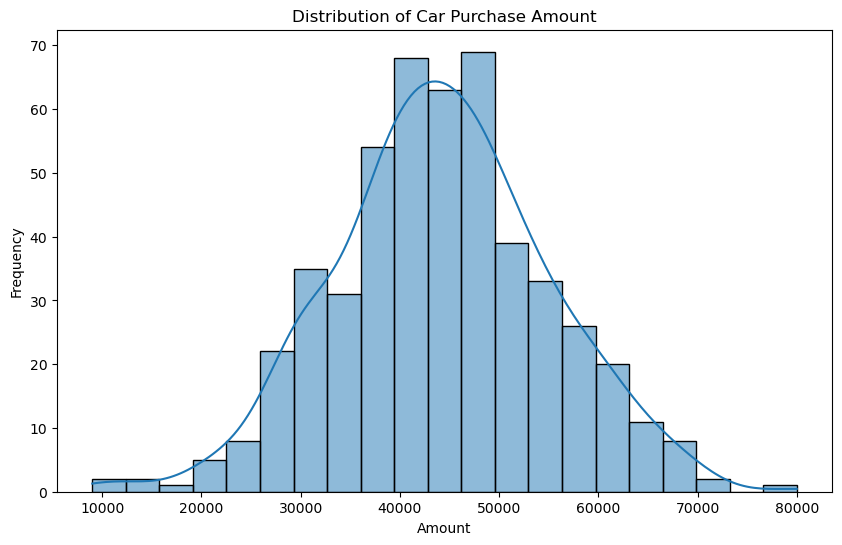

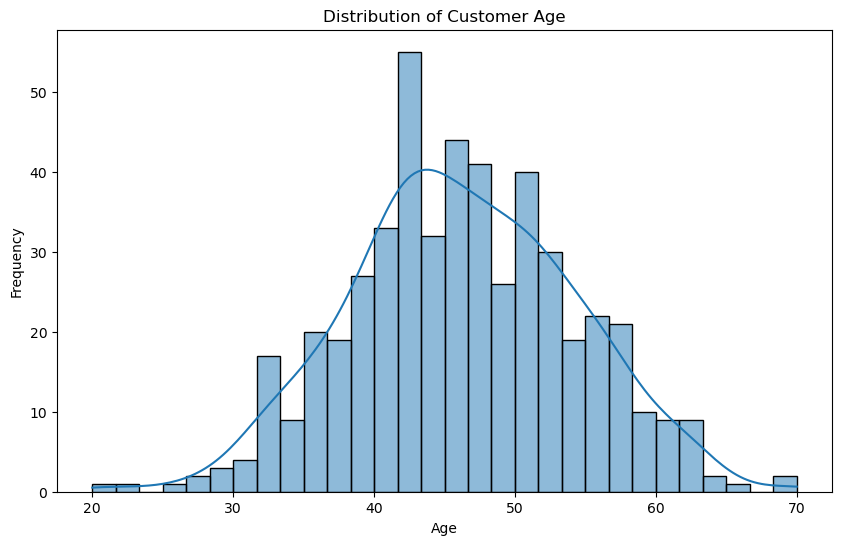

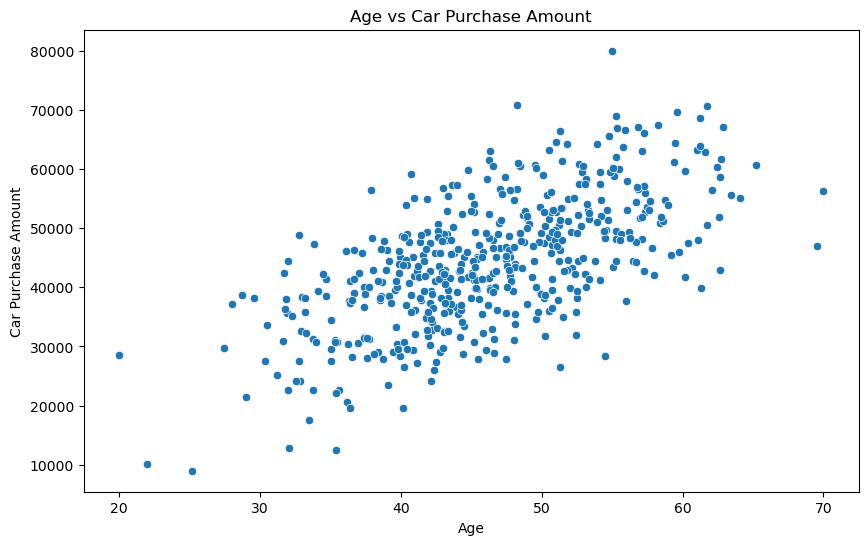

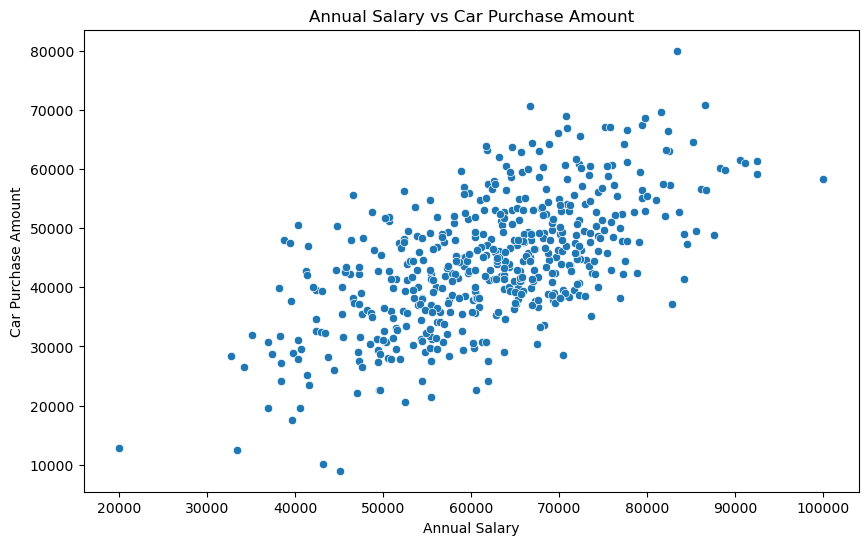

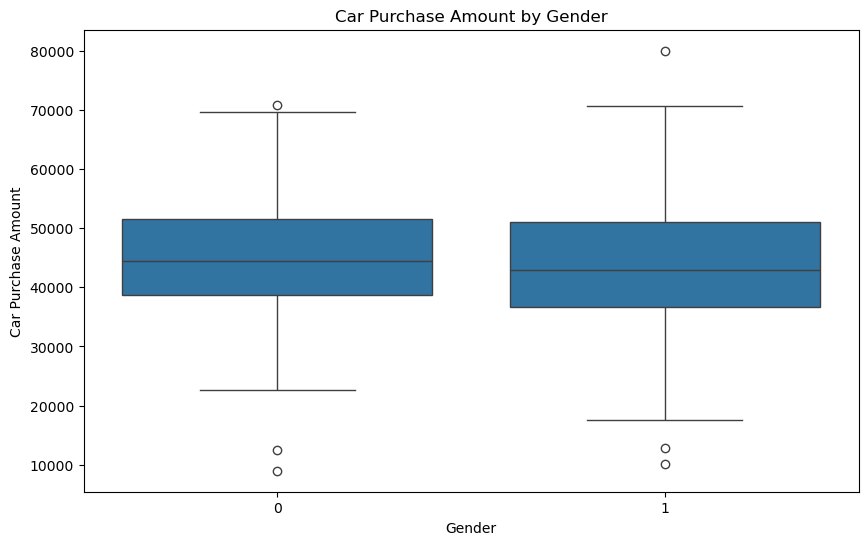

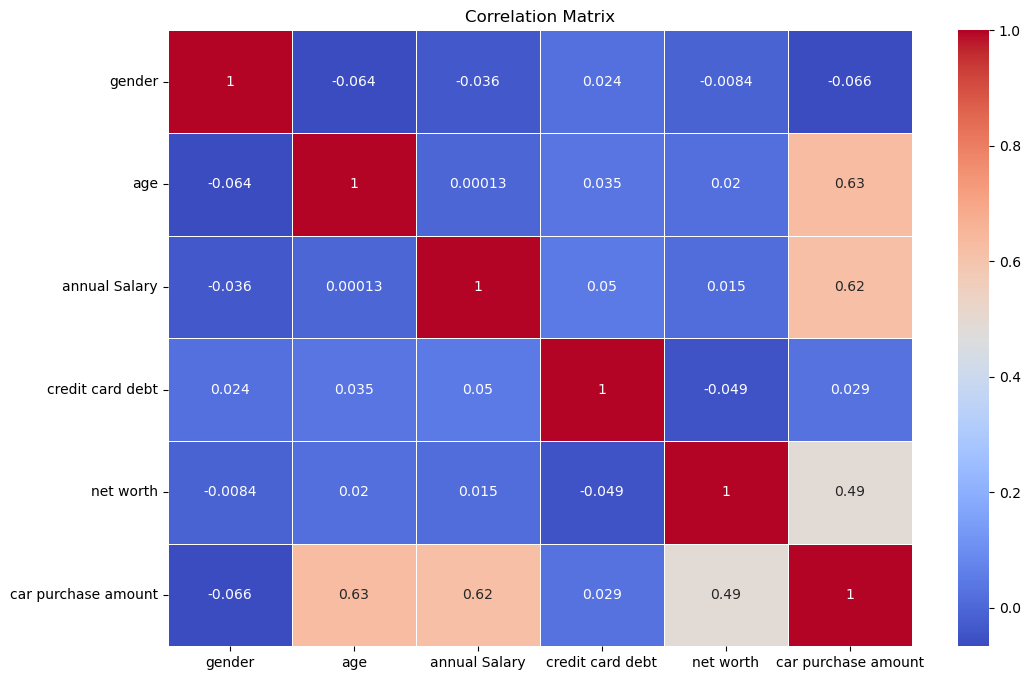

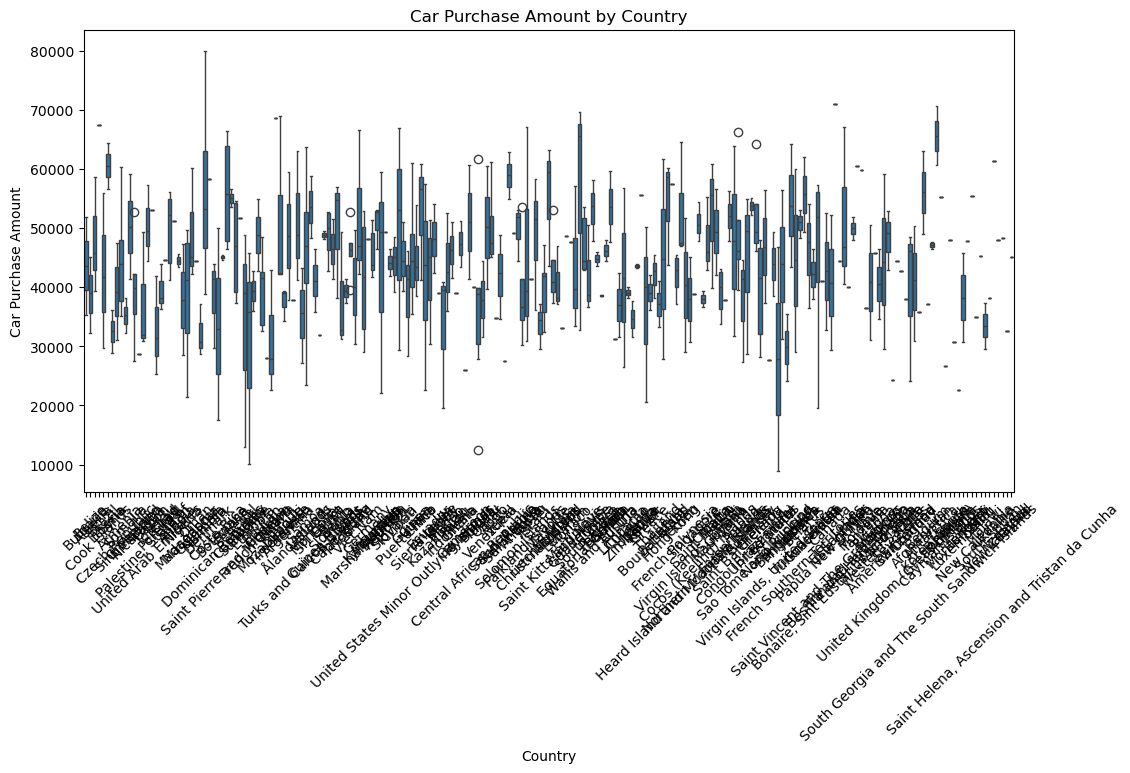

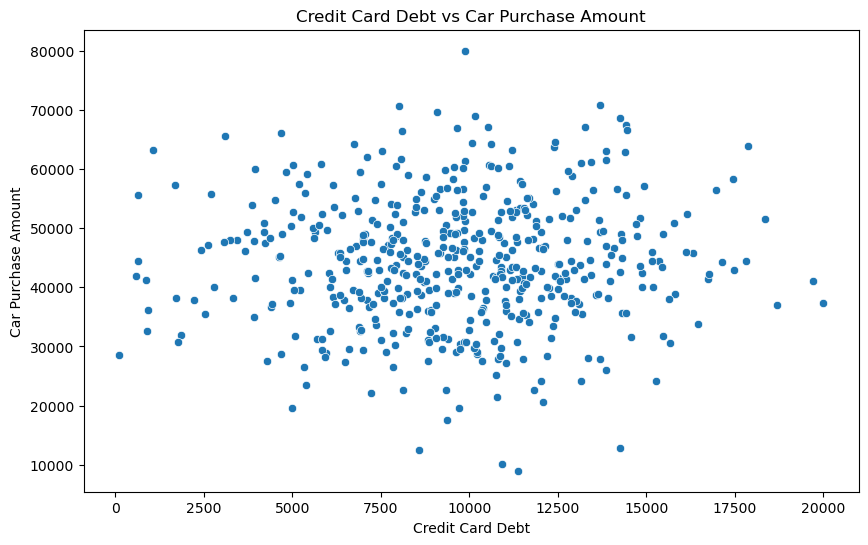

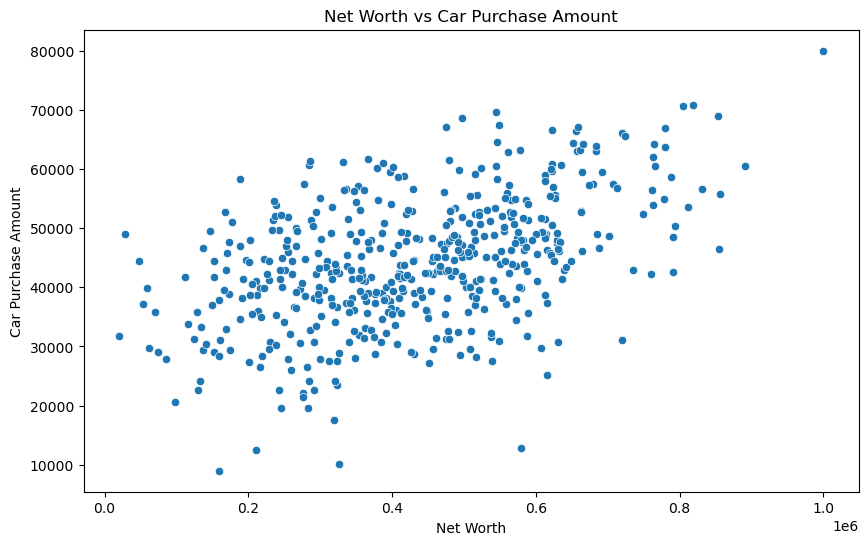

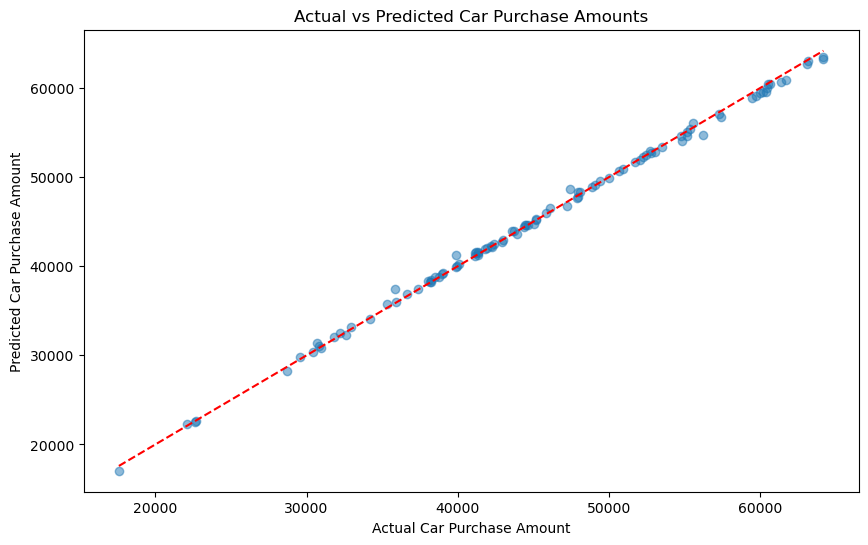

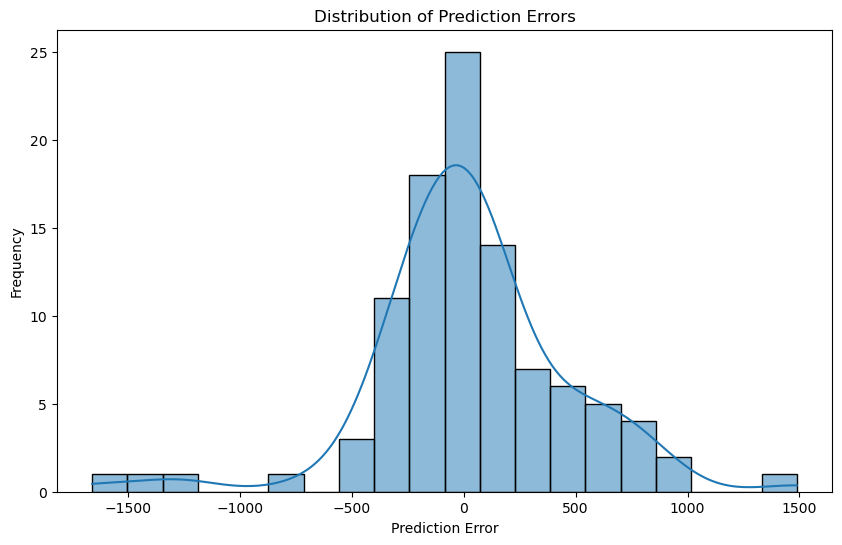

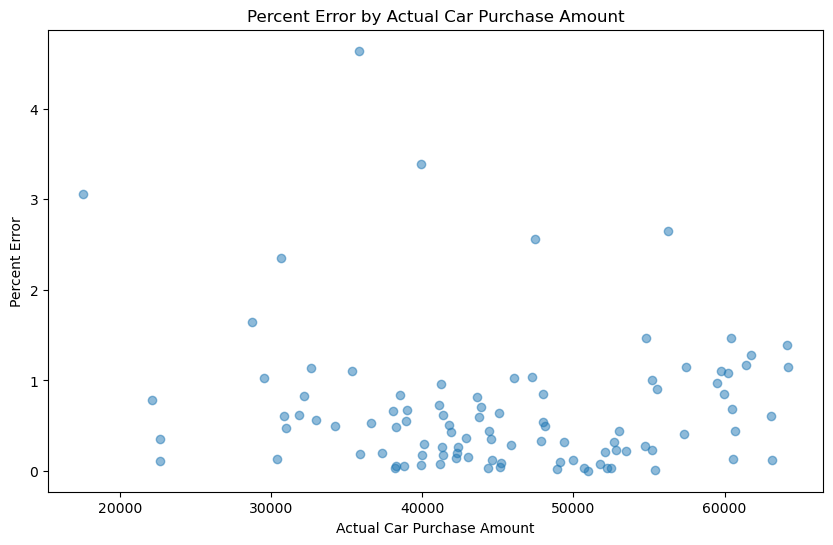

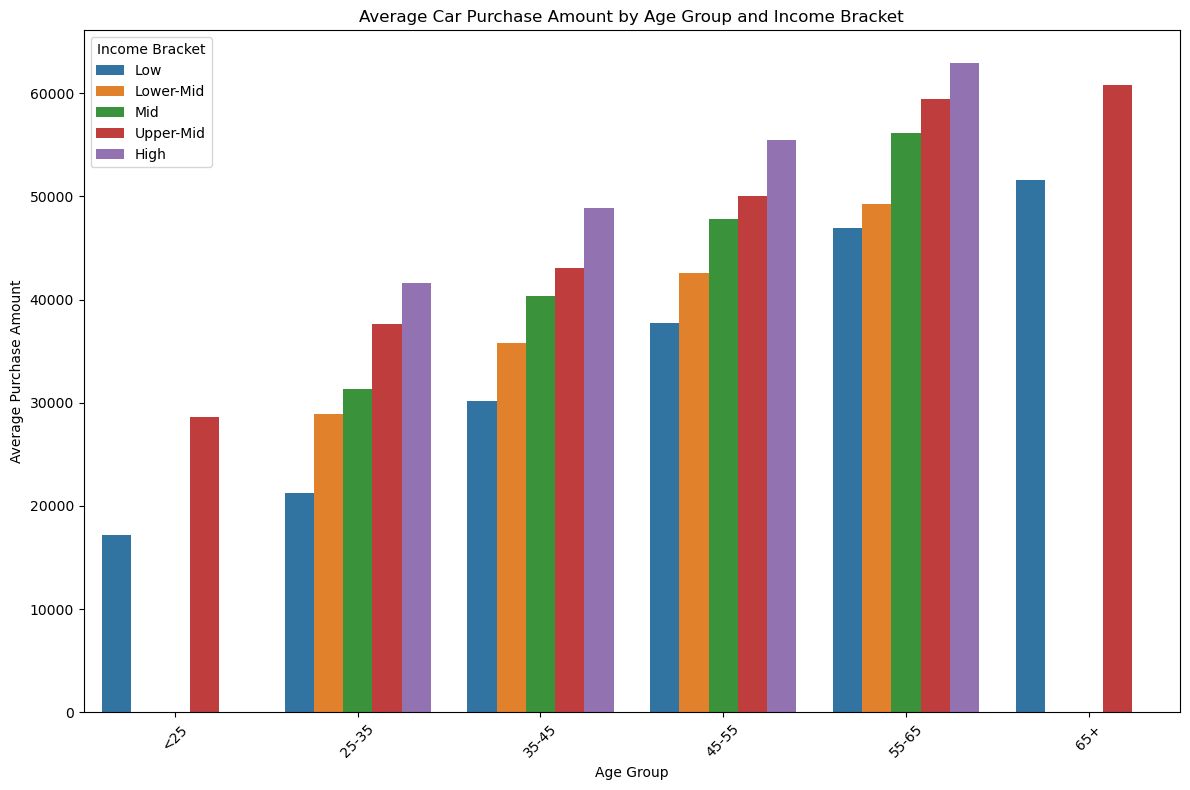

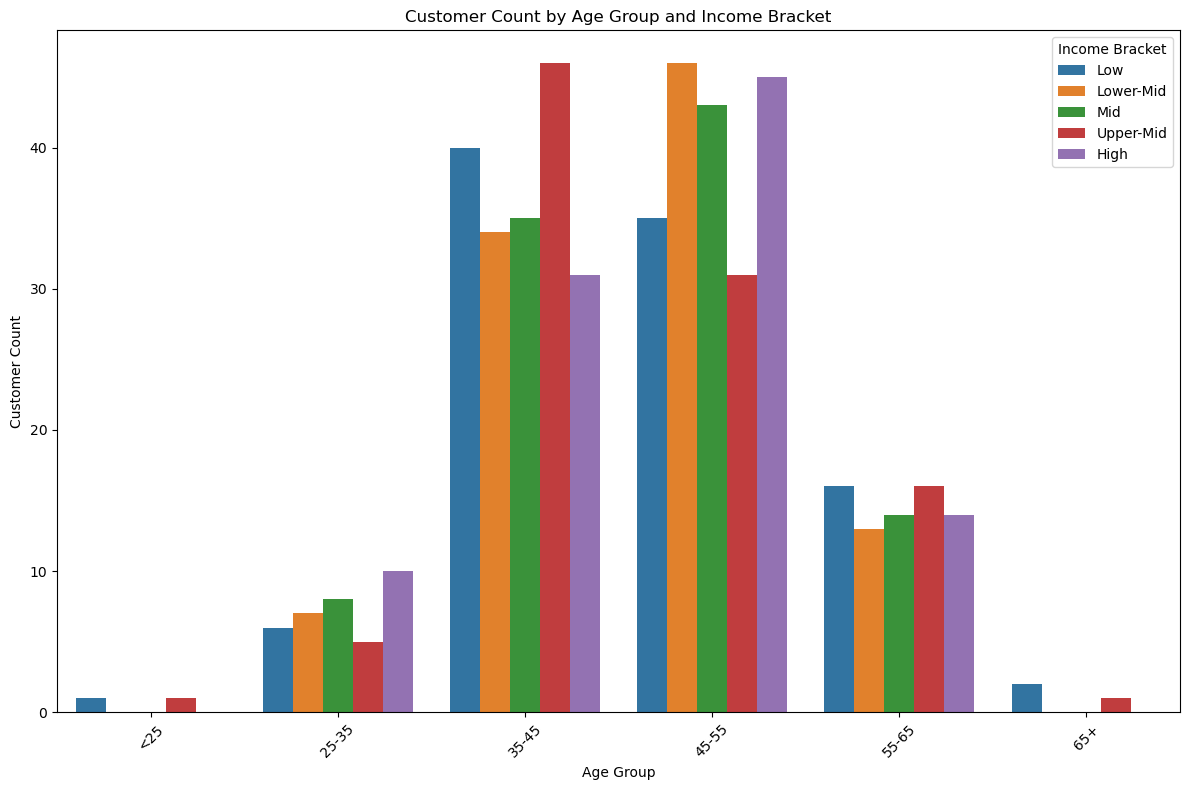

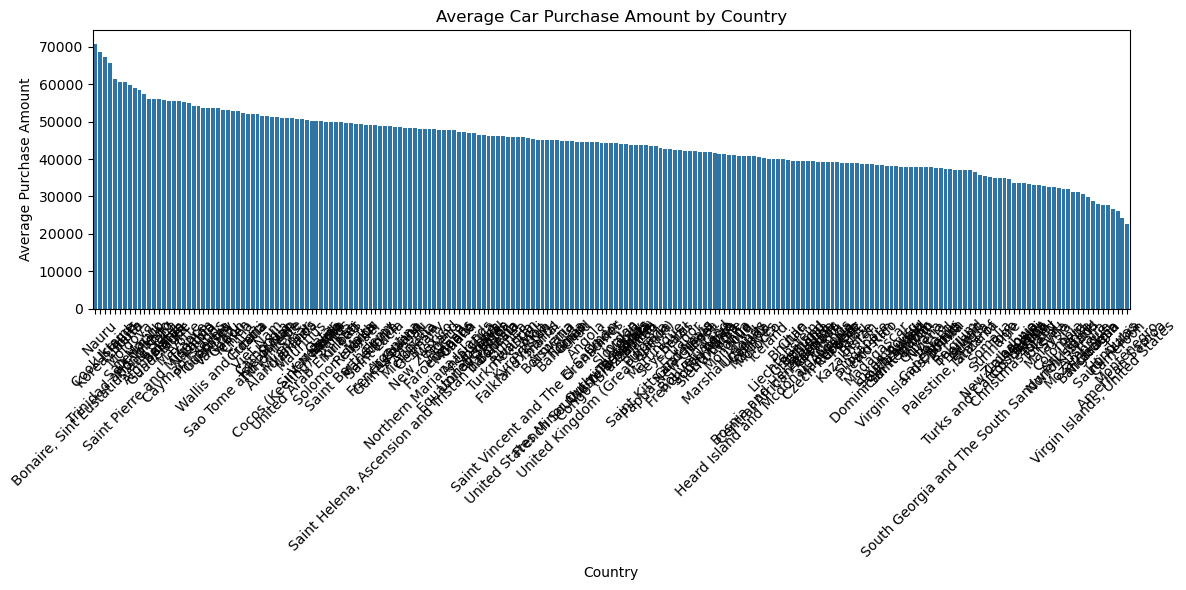

In [1]:
# Car Purchase Amount Prediction Model
# Libraries and Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import warnings
import pickle
from datetime import datetime

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Function to load and explore data
def load_and_explore_data(file_path):
    """
    Load and explore the car purchase dataset
    """
    print("Loading and exploring data...")
    
    # Load the dataset with encoding specified
    # Try with latin1 encoding first, which is more permissive
    df = pd.read_csv('Downloads/car_purchasing.csv', encoding='latin1')
    
    # Display basic information
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Rest of the function remains the same
    # ...
    
    return df
    # Display basic information
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Check data types
    print("\nData types:")
    print(df.dtypes)
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Statistical summary
    print("\nStatistical summary of numerical features:")
    print(df.describe())
    
    # Count of categorical variables
    print("\nDistribution of customers by country:")
    print(df['country'].value_counts())
    
    print("\nDistribution of customers by gender:")
    print(df['gender'].value_counts())
    
    return df

# Function for EDA
def perform_eda(df):
    """
    Perform exploratory data analysis on the dataset
    """
    print("\nPerforming exploratory data analysis...")
    
    # Distribution of car purchase amount
    plt.figure(figsize=(10, 6))
    sns.histplot(df['car purchase amount'], kde=True)
    plt.title('Distribution of Car Purchase Amount')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.savefig('car_purchase_distribution.png')
    
    # Age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['age'], kde=True, bins=30)
    plt.title('Distribution of Customer Age')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.savefig('age_distribution.png')
    
    # Relationship between age and car purchase amount
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='age', y='car purchase amount', data=df)
    plt.title('Age vs Car Purchase Amount')
    plt.xlabel('Age')
    plt.ylabel('Car Purchase Amount')
    plt.savefig('age_vs_purchase.png')
    
    # Relationship between annual salary and car purchase amount
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='annual Salary', y='car purchase amount', data=df)
    plt.title('Annual Salary vs Car Purchase Amount')
    plt.xlabel('Annual Salary')
    plt.ylabel('Car Purchase Amount')
    plt.savefig('salary_vs_purchase.png')
    
    # Box plot of car purchase amount by gender
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='gender', y='car purchase amount', data=df)
    plt.title('Car Purchase Amount by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Car Purchase Amount')
    plt.savefig('purchase_by_gender.png')
    
    # Correlation matrix
    plt.figure(figsize=(12, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    correlation = numeric_df.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')
    
    # Distribution of car purchase by country
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='country', y='car purchase amount', data=df)
    plt.title('Car Purchase Amount by Country')
    plt.xlabel('Country')
    plt.ylabel('Car Purchase Amount')
    plt.xticks(rotation=45)
    plt.savefig('purchase_by_country.png')
    
    # Credit card debt vs purchase amount
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='credit card debt', y='car purchase amount', data=df)
    plt.title('Credit Card Debt vs Car Purchase Amount')
    plt.xlabel('Credit Card Debt')
    plt.ylabel('Car Purchase Amount')
    plt.savefig('debt_vs_purchase.png')
    
    # Net worth vs purchase amount
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='net worth', y='car purchase amount', data=df)
    plt.title('Net Worth vs Car Purchase Amount')
    plt.xlabel('Net Worth')
    plt.ylabel('Car Purchase Amount')
    plt.savefig('networth_vs_purchase.png')
    
    print("EDA completed. Visualizations saved.")

# Function to detect and handle outliers
def handle_outliers(df, columns):
    """
    Detect and handle outliers in the specified columns
    """
    print("\nDetecting and handling outliers...")
    
    df_cleaned = df.copy()
    
    for column in columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
        print(f"Number of outliers in {column}: {len(outliers)}")
        
        # Cap outliers at the boundaries
        df_cleaned[column] = np.where(df_cleaned[column] < lower_bound, lower_bound, df_cleaned[column])
        df_cleaned[column] = np.where(df_cleaned[column] > upper_bound, upper_bound, df_cleaned[column])
    
    return df_cleaned

# Function to preprocess data
def preprocess_data(df):
    """
    Preprocess the data for model training
    """
    print("\nPreprocessing data...")
    
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Drop unnecessary columns
    df_processed = df_processed.drop(['customer name', 'customer e-mail'], axis=1)
    
    # Handle missing values
    for column in df_processed.columns:
        if df_processed[column].dtype == 'object':
            df_processed[column] = df_processed[column].fillna(df_processed[column].mode()[0])
        else:
            df_processed[column] = df_processed[column].fillna(df_processed[column].median())
    
    # Feature Engineering
    # Calculate debt-to-income ratio
    df_processed['debt_to_income'] = df_processed['credit card debt'] / df_processed['annual Salary']
    
    # Calculate purchase to income ratio
    df_processed['purchase_to_income'] = df_processed['car purchase amount'] / df_processed['annual Salary']
    
    # Calculate wealth index (simplified)
    df_processed['wealth_index'] = df_processed['net worth'] / df_processed['annual Salary']
    
    # Age groups
    df_processed['age_group'] = pd.cut(df_processed['age'], 
                                     bins=[0, 25, 35, 45, 55, 65, 100],
                                     labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])
    
    # Income brackets
    df_processed['income_bracket'] = pd.qcut(df_processed['annual Salary'], q=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High'])
    
    # Split into features and target
    X = df_processed.drop('car purchase amount', axis=1)
    y = df_processed['car purchase amount']
    
    # Identify numerical and categorical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Define preprocessing for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, preprocessor, df_processed

# Function to train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    """
    Train and evaluate multiple models for sales prediction
    """
    print("\nTraining and evaluating models...")
    
    # Dictionary to store model results
    model_results = {}
    
    # Define the models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    }
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        model_results[name] = {
            'pipeline': pipeline,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        
        # Print evaluation metrics
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"R² Score: {r2:.4f}")
    
    # Identify the best model based on R² score
    best_model_name = max(model_results, key=lambda x: model_results[x]['r2'])
    best_model = model_results[best_model_name]
    
    print(f"\nBest model: {best_model_name}")
    print(f"R² Score: {best_model['r2']:.4f}")
    print(f"RMSE: {best_model['rmse']:.2f}")
    
    return model_results, best_model_name

# Function to analyze feature importance
def analyze_feature_importance(model_results, best_model_name, X_test, preprocessor):
    """
    Analyze and visualize feature importance
    """
    print("\nAnalyzing feature importance...")
    
    # Get the best model pipeline
    best_pipeline = model_results[best_model_name]['pipeline']
    
    # Get feature names after one-hot encoding
    feature_names = []
    
    # Get the column transformer
    column_transformer = best_pipeline.named_steps['preprocessor']
    
    # Get the transformers
    transformers = column_transformer.transformers_
    
    # Get the categorical features and their encodings
    cat_transformer = None
    for name, transformer, columns in transformers:
        if name == 'cat':
            cat_transformer = transformer
            break
    
    if cat_transformer is not None and hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
        cat_features = cat_transformer.named_steps['onehot'].get_feature_names_out()
    else:
        cat_features = []
    
    # Numeric features are unchanged
    numeric_features = [col for col in X_test.select_dtypes(include=['int64', 'float64']).columns]
    
    # Combine feature names
    all_features = list(numeric_features) + list(cat_features)
    
    # Get feature importance if the model supports it
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        importances = best_pipeline.named_steps['model'].feature_importances_
        
        # Create a dataframe of feature importances
        if len(importances) == len(all_features):
            importance_df = pd.DataFrame({
                'Feature': all_features,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
            plt.title(f'Top 15 Feature Importance - {best_model_name}')
            plt.tight_layout()
            plt.savefig('feature_importance.png')
            
            print("\nTop 10 Most Important Features:")
            print(importance_df.head(10))
            
            return importance_df
    
    print("Feature importance not available for this model.")
    return None

# Function to make sales forecasts
def make_forecasts(best_model, X_train, X_test, y_train, y_test):
    """
    Make and visualize sales forecasts
    """
    print("\nMaking sales forecasts...")
    
    # Get predictions for test set
    y_pred = best_model['pipeline'].predict(X_test)
    
    # Create a dataframe with actual vs predicted values
    forecast_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Difference': y_test - y_pred,
        'Percent_Error': 100 * abs(y_test - y_pred) / y_test
    })
    
    # Summary statistics of forecast errors
    print("\nForecast Error Statistics:")
    print(forecast_df[['Difference', 'Percent_Error']].describe())
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Car Purchase Amount')
    plt.ylabel('Predicted Car Purchase Amount')
    plt.title('Actual vs Predicted Car Purchase Amounts')
    plt.savefig('actual_vs_predicted.png')
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(forecast_df['Difference'], kde=True)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.savefig('error_distribution.png')
    
    # Plot percent error by actual value
    plt.figure(figsize=(10, 6))
    plt.scatter(forecast_df['Actual'], forecast_df['Percent_Error'], alpha=0.5)
    plt.xlabel('Actual Car Purchase Amount')
    plt.ylabel('Percent Error')
    plt.title('Percent Error by Actual Car Purchase Amount')
    plt.savefig('percent_error.png')
    
    return forecast_df

# Function to optimize marketing strategies
def optimize_marketing_strategies(df_processed, best_model):
    """
    Generate insights for optimizing marketing strategies
    """
    print("\nGenerating insights for marketing strategy optimization...")
    
    # Create customer segments based on age and income
    segments = df_processed.groupby(['age_group', 'income_bracket']).agg({
        'car purchase amount': ['mean', 'count'],
        'annual Salary': 'mean',
        'credit card debt': 'mean',
        'net worth': 'mean'
    }).reset_index()
    
    # Flatten the multi-index columns
    segments.columns = ['_'.join(col).strip('_') for col in segments.columns.values]
    
    # Rename columns for clarity
    segments = segments.rename(columns={
        'car purchase amount_mean': 'avg_purchase_amount',
        'car purchase amount_count': 'customer_count',
        'annual Salary_mean': 'avg_salary',
        'credit card debt_mean': 'avg_debt',
        'net worth_mean': 'avg_net_worth'
    })
    
    # Calculate average purchase to income ratio by segment
    segments['avg_purchase_to_income'] = segments['avg_purchase_amount'] / segments['avg_salary']
    
    # Sort by average purchase amount to identify high-value segments
    high_value_segments = segments.sort_values('avg_purchase_amount', ascending=False).head(5)
    print("\nTop 5 High-Value Customer Segments:")
    print(high_value_segments)
    
    # Sort by customer count to identify largest segments
    largest_segments = segments.sort_values('customer_count', ascending=False).head(5)
    print("\nTop 5 Largest Customer Segments:")
    print(largest_segments)
    
    # Sort by purchase to income ratio to identify most willing spenders
    willing_spenders = segments.sort_values('avg_purchase_to_income', ascending=False).head(5)
    print("\nTop 5 Segments with Highest Purchase to Income Ratio:")
    print(willing_spenders)
    
    # Visualize high-value segments
    plt.figure(figsize=(12, 8))
    sns.barplot(x='age_group', y='avg_purchase_amount', hue='income_bracket', data=segments)
    plt.title('Average Car Purchase Amount by Age Group and Income Bracket')
    plt.xlabel('Age Group')
    plt.ylabel('Average Purchase Amount')
    plt.xticks(rotation=45)
    plt.legend(title='Income Bracket')
    plt.tight_layout()
    plt.savefig('segment_purchase_amount.png')
    
    # Visualize segment sizes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='age_group', y='customer_count', hue='income_bracket', data=segments)
    plt.title('Customer Count by Age Group and Income Bracket')
    plt.xlabel('Age Group')
    plt.ylabel('Customer Count')
    plt.xticks(rotation=45)
    plt.legend(title='Income Bracket')
    plt.tight_layout()
    plt.savefig('segment_sizes.png')
    
    # Analyze purchase patterns by country
    country_analysis = df_processed.groupby('country').agg({
        'car purchase amount': ['mean', 'count'],
        'annual Salary': 'mean'
    }).reset_index()
    
    # Flatten the multi-index columns
    country_analysis.columns = ['_'.join(col).strip('_') for col in country_analysis.columns.values]
    
    # Rename columns for clarity
    country_analysis = country_analysis.rename(columns={
        'car purchase amount_mean': 'avg_purchase_amount',
        'car purchase amount_count': 'customer_count',
        'annual Salary_mean': 'avg_salary'
    })
    
    # Calculate average purchase to income ratio by country
    country_analysis['avg_purchase_to_income'] = country_analysis['avg_purchase_amount'] / country_analysis['avg_salary']
    
    print("\nCar Purchase Analysis by Country:")
    print(country_analysis.sort_values('avg_purchase_amount', ascending=False))
    
    # Visualize purchase patterns by country
    plt.figure(figsize=(12, 6))
    sns.barplot(x='country', y='avg_purchase_amount', data=country_analysis.sort_values('avg_purchase_amount', ascending=False))
    plt.title('Average Car Purchase Amount by Country')
    plt.xlabel('Country')
    plt.ylabel('Average Purchase Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('country_purchase_amount.png')
    
    # Generate marketing strategy recommendations
    print("\nMarketing Strategy Recommendations:")
    print("1. Target High-Value Segments:")
    for _, row in high_value_segments.head(3).iterrows():
        print(f"   - Focus on {row['age_group']} age group with {row['income_bracket']} income")
        print(f"     Average purchase: ${row['avg_purchase_amount']:.2f}, Customer count: {row['customer_count']}")
    
    print("\n2. Geographic Targeting:")
    for _, row in country_analysis.sort_values('avg_purchase_amount', ascending=False).head(3).iterrows():
        print(f"   - Prioritize {row['country']} market")
        print(f"     Average purchase: ${row['avg_purchase_amount']:.2f}, Customer count: {row['customer_count']}")
    
    print("\n3. Value-Conscious Targeting:")
    for _, row in willing_spenders.head(3).iterrows():
        print(f"   - Special promotions for {row['age_group']} age group with {row['income_bracket']} income")
        print(f"     Purchase to income ratio: {row['avg_purchase_to_income']:.4f}")
    
    # Return the segment analysis for further use
    return segments, country_analysis

# Main function
def main(file_path):
    """
    Main function to run the sales forecasting pipeline
    """
    start_time = datetime.now()
    print(f"Starting sales forecasting pipeline at {start_time}")
    
    # 1. Load and explore data
    df = load_and_explore_data(file_path)
    
    # 2. Perform EDA
    perform_eda(df)
    
    # 3. Handle outliers in numerical columns
    numerical_columns = ['age', 'annual Salary', 'credit card debt', 'net worth', 'car purchase amount']
    df_cleaned = handle_outliers(df, numerical_columns)
    
    # 4. Preprocess data
    X_train, X_test, y_train, y_test, preprocessor, df_processed = preprocess_data(df_cleaned)
    
    # 5. Train and evaluate models
    model_results, best_model_name = train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)
    
    # 6. Analyze feature importance
    importance_df = analyze_feature_importance(model_results, best_model_name, X_test, preprocessor)
    
    # 7. Make forecasts
    forecast_df = make_forecasts(model_results[best_model_name], X_train, X_test, y_train, y_test)
    
    # 8. Optimize marketing strategies
    segments, country_analysis = optimize_marketing_strategies(df_processed, model_results[best_model_name])
    
    # 9. Save the best model
    best_model = model_results[best_model_name]['pipeline']
    with open('car_purchase_prediction_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)
    
    end_time = datetime.now()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time}")
    print("\nCar Purchase Amount Prediction Model Complete!")
    
    return model_results, best_model_name, forecast_df, segments, country_analysis

if __name__ == "__main__":
    # Path to the dataset
    file_path = "Downloads/car_purchasing.csv" 
    
    # Run the pipeline
    model_results, best_model_name, forecast_df, segments, country_analysis = main(file_path)